# Analysis of network growth

## Load data

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt, matplotlib as mpl
import numpy as np
import igraph as ig
import random
from tqdm import tqdm
import statsmodels.formula.api as smf
import itertools
import pickle

In [2]:
df_edges: pd.DataFrame = pd.read_pickle('../data/generated/graph/actor_graph_full.ungrouped.pkl')
df_movies: pd.DataFrame = pd.read_pickle('../data/generated/preprocessed/movies.pkl')

## Prepare temporal graphs edges

In [3]:
df_edges['movie_release'] = df_movies.set_index('fb_id').loc[df_edges.movie_fbid].movie_release.values
df_edges.sort_values('movie_release', inplace=True)

print(f'length before purge : {len(df_edges)}')
df_edges.dropna(subset='movie_release', inplace=True)  # some movies do not have dates associated to them
# df_edges.drop(index=df_edges[((df_edges.movie_release <= min(years_bins)) | (df_edges.movie_release > max(years_bins)))].index, inplace=True)
# df_edges.drop(index=df_edges[(df_edges.movie_release > 2015)].index, inplace=True)
print(f'length after purge : {len(df_edges)}')

# assert min(years_bins) < df_edges.movie_release.min()
# assert df_edges.movie_release.max() <= max(years_bins)

df_edges['movie_release_year'] = df_edges['movie_release'].map(lambda t: t.year).astype(pd.Int64Dtype())

# we bin the years together to reduce noise on the subsequent analyses
# we consider the graph at t=0 at year 1920
df_edges['year_bin'] = pd.cut(df_edges.query('movie_release_year > 1920').movie_release_year, range(1920, 2010+1, 10), precision=0)
df_edges['year_qbin'] = pd.qcut(df_edges.query('movie_release_year > 1920').movie_release_year, len(range(1920, 2010+1, 10))-1, precision=0)

df_edges

length before purge : 2241657
length after purge : 2224839


,actor1_fbid,actor2_fbid,movie_fbid,movie_release,movie_release_year,year_bin,year_qbin
678016,/m/0k2pyv,/m/0k2pz0,/m/044ggd,1888-01-01,1888,NaN,NaN
678017,/m/0k2pyv,/m/0k2pz6,/m/044ggd,1888-01-01,1888,NaN,NaN
678018,/m/0k2pyv,/m/0k2pzd,/m/044ggd,1888-01-01,1888,NaN,NaN
678019,/m/0k2pz0,/m/0k2pz6,/m/044ggd,1888-01-01,1888,NaN,NaN
678020,/m/0k2pz0,/m/0k2pzd,/m/044ggd,1888-01-01,1888,NaN,NaN
...,...,...,...,...,...,...,...
1118305,/m/06k6ns,/m/0fqwzd,/m/064mmw7,2016-06-08,2016,NaN,"(2009.0, 2016.0]"
1118306,/m/06k6ns,/m/0fdc74,/m/064mmw7,2016-06-08,2016,NaN,"(2009.0, 2016.0]"
1118307,/m/0fdc74,/m/0fqwzd,/m/064mmw7,2016-06-08,2016,NaN,"(2009.0, 2016.0]"
1118296,/m/0736qr,/m/0fqwzd,/m/064mmw7,2016-06-08,2016,NaN,"(2009.0, 2016.0]"


In [4]:
years = df_edges.movie_release_year.unique().astype(int)

## Model growth

We consider the initial actor network at the year 1900

https://barabasi.com/f/622.pdf

Is there preferential attachment ?

### Numerical indices

We use numerical indices instead of freebase ids, in order to index into numpy arrays later

In [5]:
codes, uniques = pd.factorize(pd.concat([df_edges.actor1_fbid, df_edges.actor2_fbid]))
df_edges['actor1_numid'] = codes[:len(df_edges)]
df_edges['actor2_numid'] = codes[len(df_edges):]
df_edges

,actor1_fbid,actor2_fbid,movie_fbid,movie_release,movie_release_year,year_bin,year_qbin,actor1_numid,actor2_numid
678016,/m/0k2pyv,/m/0k2pz0,/m/044ggd,1888-01-01,1888,NaN,NaN,0,1
678017,/m/0k2pyv,/m/0k2pz6,/m/044ggd,1888-01-01,1888,NaN,NaN,0,2
678018,/m/0k2pyv,/m/0k2pzd,/m/044ggd,1888-01-01,1888,NaN,NaN,0,119615
678019,/m/0k2pz0,/m/0k2pz6,/m/044ggd,1888-01-01,1888,NaN,NaN,1,2
678020,/m/0k2pz0,/m/0k2pzd,/m/044ggd,1888-01-01,1888,NaN,NaN,1,119615
...,...,...,...,...,...,...,...,...,...
1118305,/m/06k6ns,/m/0fqwzd,/m/064mmw7,2016-06-08,2016,NaN,"(2009.0, 2016.0]",61010,52747
1118306,/m/06k6ns,/m/0fdc74,/m/064mmw7,2016-06-08,2016,NaN,"(2009.0, 2016.0]",61010,80735
1118307,/m/0fdc74,/m/0fqwzd,/m/064mmw7,2016-06-08,2016,NaN,"(2009.0, 2016.0]",80735,52747
1118296,/m/0736qr,/m/0fqwzd,/m/064mmw7,2016-06-08,2016,NaN,"(2009.0, 2016.0]",41038,52747


In [6]:
print(f'total {uniques.nunique()} nodes (actors)')

total 134649 nodes (actors)


### Compute degree evolution

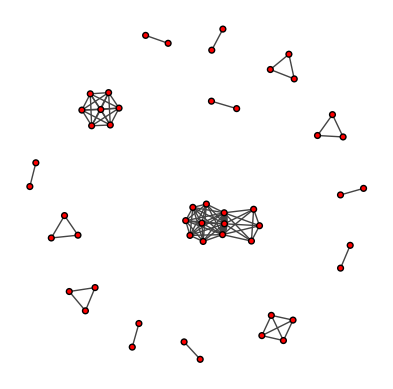

In [7]:
def get_edges_year(year: int) -> pd.DataFrame:
	"""Return weighted edges for all movies released before and on ``year``"""
	return (df_edges
		.query(f'movie_release_year <= {year}')
		.groupby(['actor1_numid', 'actor2_numid'])
		[['movie_fbid']]
		.nunique()
		.reset_index()
		.rename(columns={'movie_fbid': 'movie_count'})
	)

# test the function
random.seed(0)  # seed the random layout
fig, ax = plt.subplots()
g0 = ig.Graph.DataFrame(get_edges_year(years[10])[['actor1_numid', 'actor2_numid', 'movie_count']], directed=False, use_vids=False)
ig.plot(g0, target=ax,
	# vertex_label=g0.vs['name'], vertex_label_size=7,
	edge_width=g0.es['movie_count']
);

#### Run computation

Note : actors keep their degree even after they die !

In [8]:
if False:  # recompute
	degrees = np.zeros((uniques.nunique(), df_edges.movie_release_year.nunique()))

	for iyear, year in tqdm(enumerate(years), total=len(years)):
		g = ig.Graph.DataFrame(get_edges_year(year)[['actor1_numid', 'actor2_numid', 'movie_count']], directed=False, use_vids=False)
		# print(g.summary())
		for node, k in zip(g.vs, g.degree()):
			degrees[node['name'], iyear] = k
	
	np.savez('../data/generated/graph/network_growth/actor_graph_full_degrees.npz', degrees)

else:  # load from precomputed
	degrees = np.load('../data/generated/graph/network_growth/actor_graph_full_degrees.npz')['arr_0']

In [9]:
delta_degrees = np.diff(degrees, axis=-1)

In [10]:
# k = 0 corresponds to actors not yet born
degrees[degrees == 0] = np.nan
# Delta k = 0 corresponds to actors that don't evolve
delta_degrees[delta_degrees == 0] = np.nan

In [11]:
# convert the data to a dataframe
df_degree = pd.DataFrame(degrees, columns=years).melt(var_name='year', value_name='k', ignore_index=False)
df_degree.dropna(inplace=True)
df_degree.reset_index(inplace=True, names='actor_numid')

df_delta_degree = pd.DataFrame(delta_degrees, columns=years[:-1]).melt(var_name='year', value_name='dk', ignore_index=False)
df_delta_degree.dropna(inplace=True)
df_delta_degree.reset_index(inplace=True, names='actor_numid')

df_pref_attachment_delta = pd.merge(df_delta_degree, df_degree, how='inner', on=['actor_numid', 'year'])

In [12]:
df_pref_attachment_delta

,actor_numid,year,dk,k
0,7,1898,4.0,1.0
1,12,1898,4.0,1.0
2,7,1901,6.0,5.0
3,11,1901,6.0,5.0
4,12,1901,6.0,5.0
...,...,...,...,...
195683,51342,2015,1.0,149.0
195684,52861,2015,4.0,57.0
195685,61062,2015,1.0,114.0
195686,73797,2015,1.0,51.0


### Degree evolution

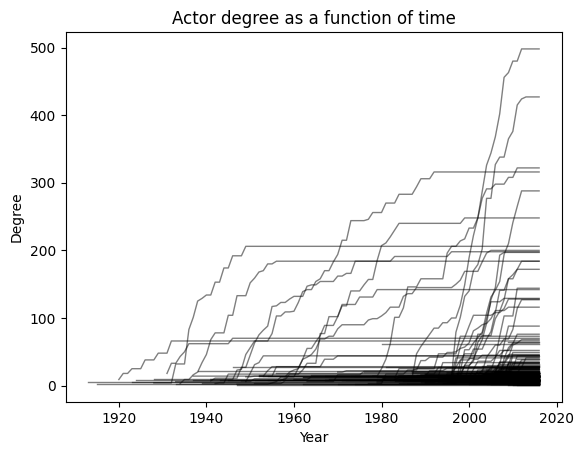

In [13]:
fig, ax = plt.subplots()
np.random.seed(0)
# we plot only 256 actors because plotting all 1.3M of them would take ages !!
ax.plot(years, degrees[np.random.randint(0, len(degrees), 256)].T, color='black', alpha=0.5, linewidth=1)
ax.set_xlabel('Year')
ax.set_ylabel('Degree')
ax.set_title('Actor degree as a function of time')
plt.show()

The degree seems to grow linearly in time, but faster when actors enter late into the graph !

See the preliminary evidence based on degree growth

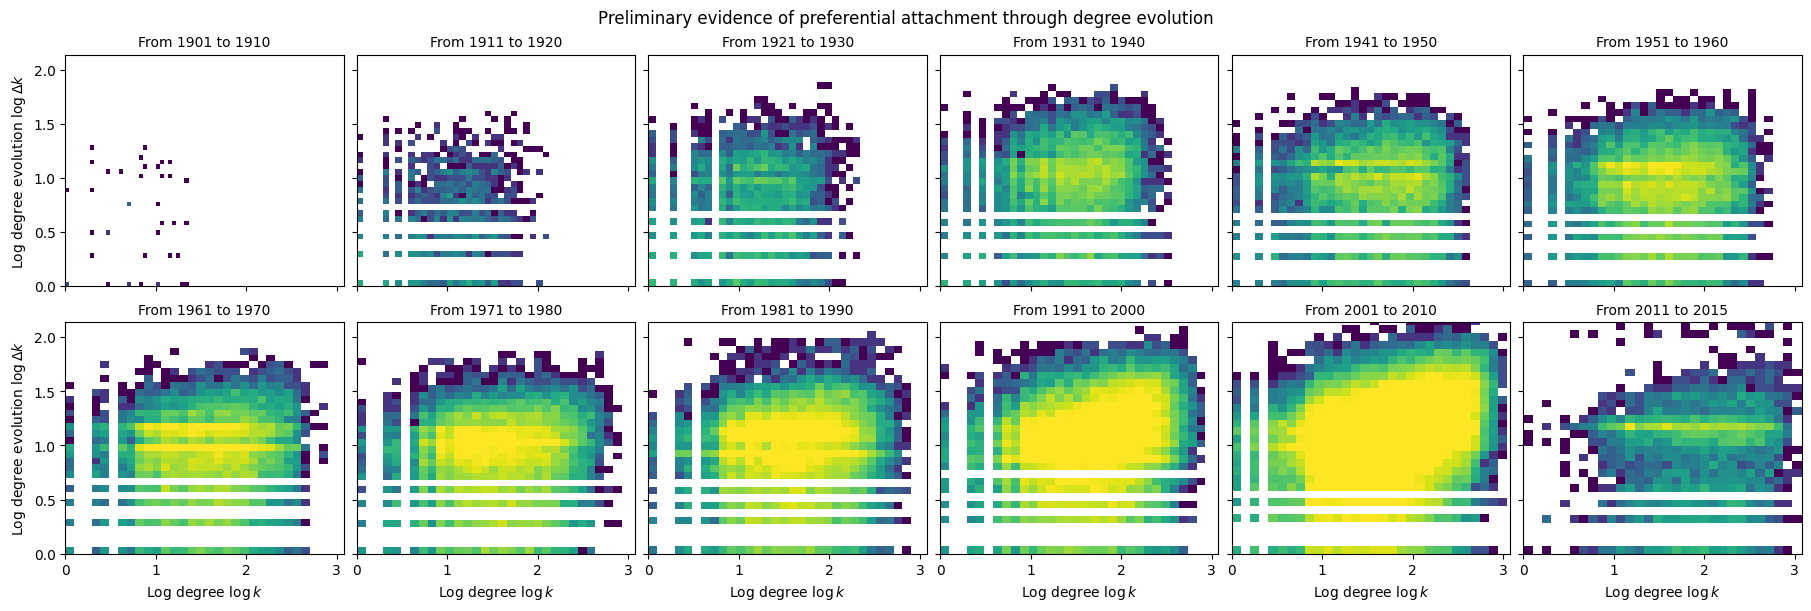

In [14]:
fig, axs = plt.subplots(figsize=(6*3, 2*3), ncols=6, nrows=2, sharex=True, sharey=True, constrained_layout=True)

df_pref_attachment_delta['year_bin'] = pd.cut(df_pref_attachment_delta.year, range(1900, 2020+1, 10))

for (year_bin, df_pref_attachment_delta_bin), ax in zip(df_pref_attachment_delta.groupby('year_bin'), axs.flat):
	# ax.plot(df_pref_attachment_delta_bin.k, df_pref_attachment_delta_bin.dk, '.', markersize=2, alpha=0.2)
	ax.hist2d(
		np.log10(df_pref_attachment_delta_bin.k), np.log10(df_pref_attachment_delta_bin.dk),
		bins=[30,30], norm='log', vmin=1, vmax=100, cmap='viridis'
	)
	# NOTE : we don't use year_bin.right because then we get "From 2011 to 2020" 
	ax.set_title(f'From {year_bin.left+1} to {df_pref_attachment_delta_bin.year.max()}', fontsize='medium')
	# ax.set_xscale('log')
	# ax.set_yscale('log')
	ax.set_xlabel('Log degree $\\log k$')
	ax.set_ylabel('Log degree evolution $\\log \\Delta k$')
	ax.label_outer()

fig.suptitle('Preliminary evidence of preferential attachment through degree evolution')

plt.show()

### Preferential attachment

See also Jeong et al, 2003

We consider adding actors to the graph progressively, and not considering edges created between existing actors.

Each actor appears for the first time in a movie, and using the first movie release date we can prune the edges that do not correspond to the first addition.

We want to estimate

$\Pi(k_i) = \frac{k_i}{\sum_j k_j} \approx \frac{\text{number of new connections to node } i}{\text{total number of new connections}}$

- Take the distribution of edges at t0
- Add edges, and see where they connect
- The probability Pi(k) = [histogrammed probability of new connections @ k] / [histogram probability of degree distribution @ k],
- then normalize Pi(k)
- The denominator normalizes the fact high degrees are more rare, but nodes proportionally connect more to them


Note : we do not consider internal links

##### Add actors by batches

In order to have a good estimate, we batch edges together by movie release year, so that the probability estimate is not too noisy

cut : binning every 10 years<br>
qcut : binning 12 quartiles

In [15]:
if False:  # recompute
	for binning_method in ['year_bin', 'year_qbin']:
		g = ig.Graph.DataFrame(df_edges.query('movie_release_year <= 1920')[['actor1_fbid', 'actor2_fbid']], directed=False, use_vids=False)
		pa_internal = []
		pa_external = []
		degree_distribution = {}

		for bin, df_edges_bin in tqdm(df_edges.query('1920 < movie_release_year').groupby(binning_method, sort=False)):
			degrees = g.degree()
			degree_lookup = dict(zip([ v['name'] for v in g.vs ], degrees))
			degree_distribution[bin] = pd.Series(degrees).value_counts(normalize=True).sort_index()
			new_actors = set()

			for _, edge in df_edges_bin.iterrows():
				actor1_degree = degree_lookup.get(edge.actor1_fbid, 0)
				actor2_degree = degree_lookup.get(edge.actor2_fbid, 0)
				
				if actor1_degree == 0:
					new_actors.add(edge.actor1_fbid)
				if actor2_degree == 0:
					new_actors.add(edge.actor2_fbid)

				# both added at the same time. ignore
				if actor1_degree == 0 and actor2_degree == 0:
					continue

				# external edge
				if actor1_degree == 0 and actor2_degree > 0:
					pa_external.append((actor2_degree, bin))
				if actor1_degree > 0 and actor2_degree == 0:
					pa_external.append((actor1_degree, bin))

				# internal edge
				if actor1_degree > 0 and actor2_degree > 0:
					pa_internal.append((actor1_degree*actor2_degree, bin))

			g.add_vertices(list(new_actors))
			g.add_edges(zip(df_edges_bin.actor1_fbid, df_edges_bin.actor2_fbid))

		df_pa_external = pd.DataFrame(pa_external, columns=['k', 'bin'])
		df_pa_internal = pd.DataFrame(pa_internal, columns=['k1k2', 'bin'])
		df_degree_distribution = (pd.DataFrame(degree_distribution)
			.melt(var_name='bin', value_name='p_k', ignore_index=False)
			.reset_index(names='k')
			.dropna()
		)

		if True:  # save to disk
			df_pa_external.to_pickle(f'../data/generated/graph/network_growth/pa_external_{binning_method}.pkl')
			df_pa_internal.to_pickle(f'../data/generated/graph/network_growth/pa_internal_{binning_method}.pkl')
			df_degree_distribution.to_pickle(f'../data/generated/graph/network_growth/degree_distribution_{binning_method}.pkl')


df_pa_external_year_bin = pd.read_pickle('../data/generated/graph/network_growth/pa_external_year_bin.pkl')
df_pa_internal_year_bin = pd.read_pickle('../data/generated/graph/network_growth/pa_internal_year_bin.pkl')
df_degree_distribution_year_bin = pd.read_pickle('../data/generated/graph/network_growth/degree_distribution_year_bin.pkl')
df_pa_external_year_qbin = pd.read_pickle('../data/generated/graph/network_growth/pa_external_year_qbin.pkl')
df_pa_internal_year_qbin = pd.read_pickle('../data/generated/graph/network_growth/pa_internal_year_qbin.pkl')
df_degree_distribution_year_qbin = pd.read_pickle('../data/generated/graph/network_growth/degree_distribution_year_qbin.pkl')

In [16]:
# assert the distributions are correctly normalized
assert (df_degree_distribution_year_bin.groupby('bin').p_k.sum() > 0.999).all()
assert (df_degree_distribution_year_qbin.groupby('bin').p_k.sum() > 0.999).all()

In [17]:
# inspect dataframe
df_degree_distribution_year_bin

,k,bin,p_k
0,1,"(1920, 1930]",0.060832
1,2,"(1920, 1930]",0.045526
2,3,"(1920, 1930]",0.055338
3,4,"(1920, 1930]",0.069859
4,5,"(1920, 1930]",0.062402
...,...,...,...
6148,1117,"(2000, 2010]",0.000012
6150,1143,"(2000, 2010]",0.000012
6151,1233,"(2000, 2010]",0.000012
6154,1339,"(2000, 2010]",0.000012


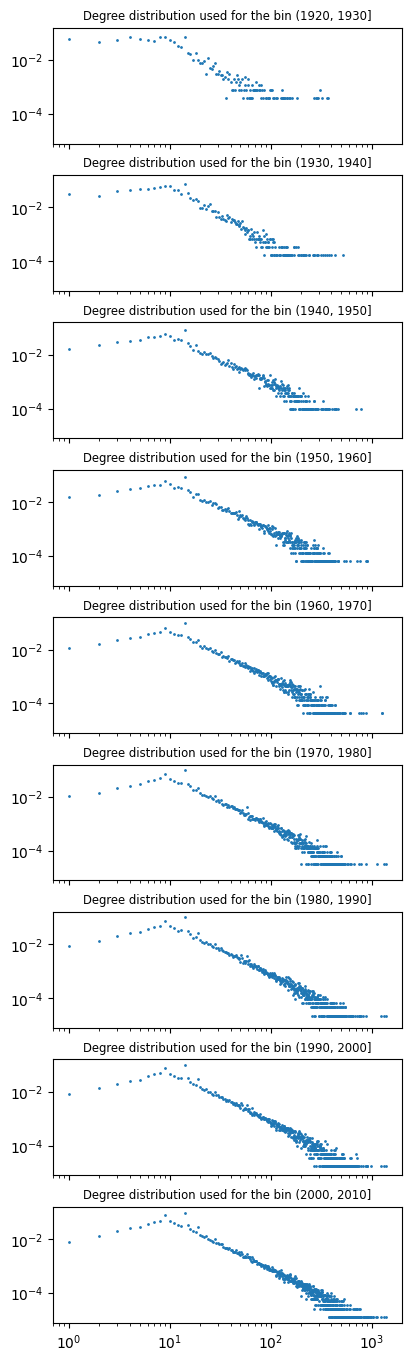

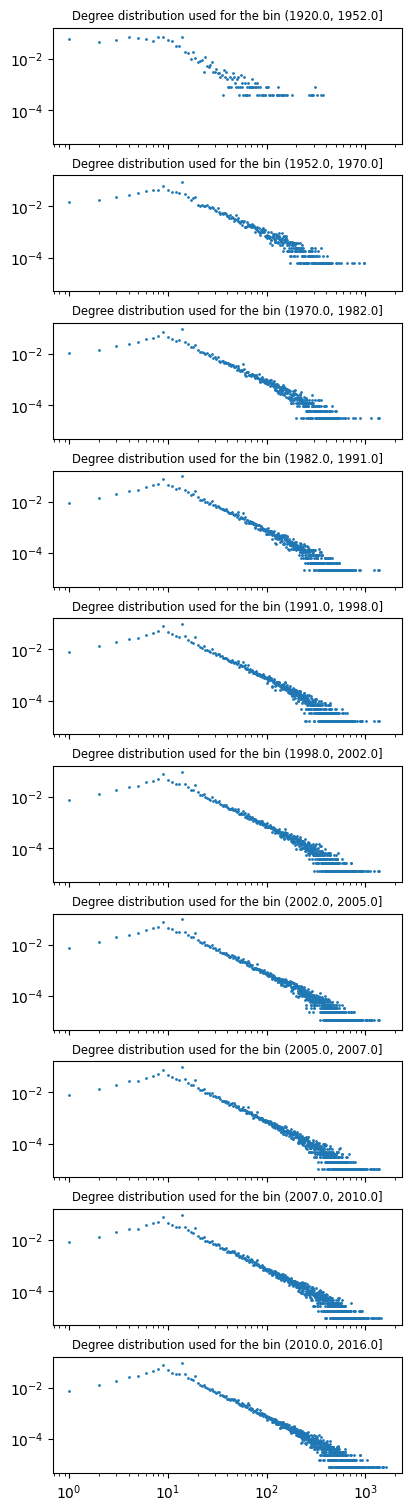

In [18]:
for df_degree_distribution in [df_degree_distribution_year_bin, df_degree_distribution_year_qbin]:
	fig, axs = plt.subplots(figsize=(4, df_degree_distribution.bin.nunique()*1.5),
		nrows=df_degree_distribution.bin.nunique(), sharex=True, sharey=True, constrained_layout=True)
	for (bin, df_degree_distribution_bin), ax in zip(df_degree_distribution.groupby('bin'), axs.flat):
		ax.plot(df_degree_distribution_bin.k, df_degree_distribution_bin.p_k, '.', markersize=2)
		ax.set_xscale('log')
		ax.set_yscale('log')
		ax.label_outer()
		ax.set_title(f'Degree distribution used for the bin {bin}', fontsize='small')
	plt.show() 

In [19]:
def compute_pi_kappa(df_pa_external, df_degree_distribution):
	pi_external = (
		df_pa_external.groupby('bin')
		.k.value_counts(normalize=True)  # histogram of edge connections as a function of k
		.sort_index()
		.rename('pi')  # distribution of edge connections
	)
	for bin in df_pa_external.bin.unique():
		# we need to divide by the distribution of edges,
		# because otherwise the histogram is biased toward the more frequent degrees
		pi_external[bin] /= (
			df_degree_distribution.query('bin == @bin')  # the distribution of degrees right before the bin of edges was added
			.set_index('k').p_k
		)
		# normalize
		pi_external[bin] /= pi_external[bin].sum()

	# compute cumulative sum
	kappa_external = pi_external.groupby('bin').cumsum().rename('kappa')

	pi_external = pi_external.reset_index()
	kappa_external = kappa_external.reset_index()

	return pi_external, kappa_external

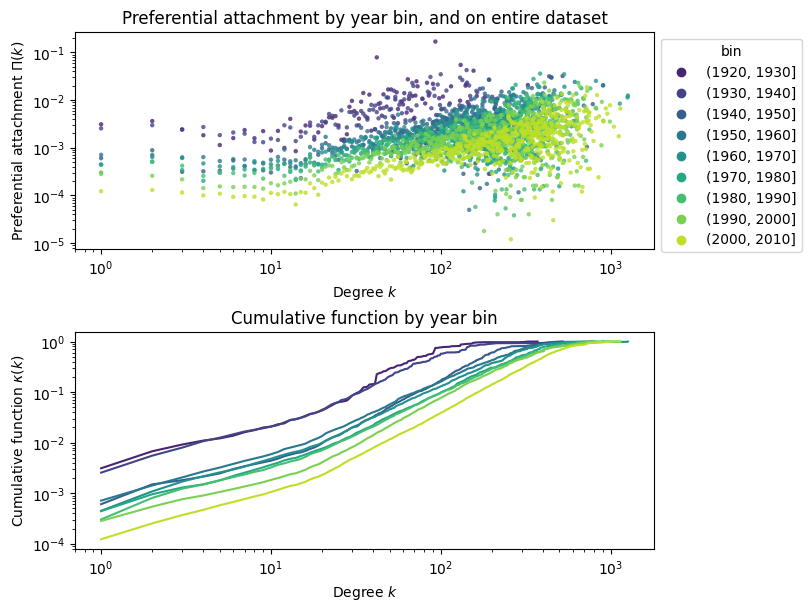

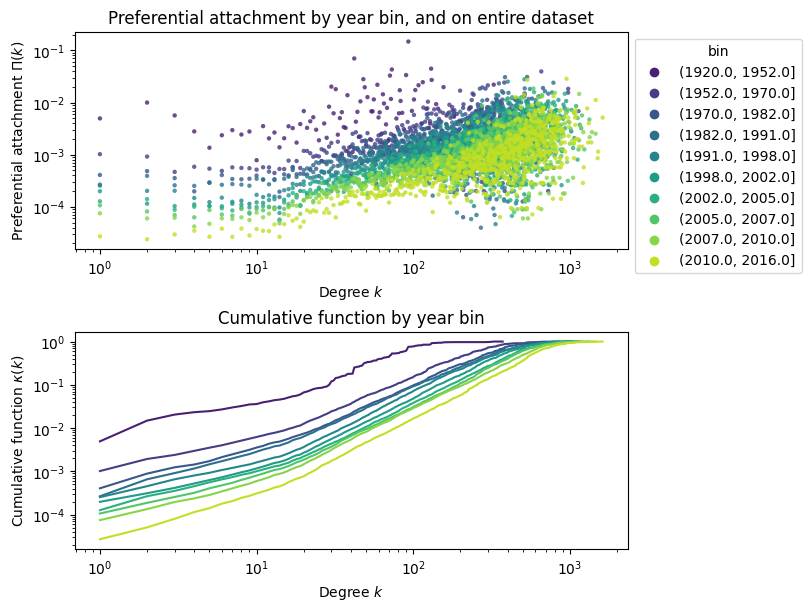

In [20]:
for df_pa_external, df_degree_distribution in [(df_pa_external_year_bin, df_degree_distribution_year_bin), (df_pa_external_year_qbin, df_degree_distribution_year_qbin)]:
	pi_external, kappa_external = compute_pi_kappa(df_pa_external, df_degree_distribution)

	fig, axs = plt.subplots(nrows=2, figsize=(8, 6), constrained_layout=True)

	sns.scatterplot(pi_external, x='k', y='pi', hue='bin', linewidth=0, alpha=0.8, s=10, palette='viridis', ax=axs[0])
	sns.move_legend(axs[0], loc='upper left', bbox_to_anchor=(1, 1))
	axs[0].set_ylabel('Preferential attachment $\\Pi(k)$')
	axs[0].set_xlabel('Degree $k$')
	axs[0].set_yscale('log')
	axs[0].set_xscale('log')
	axs[0].set_title('Preferential attachment by year bin, and on entire dataset')

	sns.lineplot(kappa_external, x='k', y='kappa', hue='bin', palette='viridis', legend=False, ax=axs[1])
	# sns.move_legend(axs[1], loc='lower right', fontsize='small')
	axs[1].set_ylabel('Cumulative function $\\kappa(k)$')
	axs[1].set_xlabel('Degree $k$')
	axs[1].set_yscale('log')
	axs[1].set_xscale('log')
	axs[1].set_title('Cumulative function by year bin')

	plt.show()

In [21]:
def compute_fitcoefs(df_kappa):
	values = []

	for bin, df_kappa_bin in df_kappa.groupby('bin'):
		if len(df_kappa_bin) >= 2:
			model = smf.ols(formula="log_kappa ~ log_k", data=dict(log_k=np.log10(df_kappa_bin.k), log_kappa=np.log10(df_kappa_bin.kappa)))
			res = model.fit()
			# display(res.summary())
			alpha_plus_one = (res.params['log_k'], *res.conf_int().loc['log_k'])
			values.append((bin, alpha_plus_one[0]-1, alpha_plus_one[1]-1, alpha_plus_one[2]-1))
		else:
			values.append((bin, np.nan, np.nan, np.nan))

	return pd.DataFrame(values, columns=['bin', 'alpha', 'ci_lower', 'ci_upper'])

In [22]:
fitcoefs = {
	'year_bin': compute_fitcoefs(compute_pi_kappa(df_pa_external_year_bin, df_degree_distribution_year_bin)[1]),
	'year_qbin': compute_fitcoefs(compute_pi_kappa(df_pa_external_year_qbin, df_degree_distribution_year_qbin)[1])
}

In [23]:
fitcoefs

{'year_bin':             bin     alpha  ci_lower  ci_upper
 0  (1920, 1930]  0.276953  0.210638  0.343267
 1  (1930, 1940]  0.210021  0.169118  0.250924
 2  (1940, 1950]  0.510332  0.476495  0.544169
 3  (1950, 1960]  0.336974  0.318484  0.355464
 4  (1960, 1970]  0.386186  0.366752  0.405619
 5  (1970, 1980]  0.433514  0.417537  0.449490
 6  (1980, 1990]  0.419824  0.405383  0.434265
 7  (1990, 2000]  0.522066  0.502441  0.541692
 8  (2000, 2010]  0.639683  0.624278  0.655087,
 'year_qbin':                 bin     alpha  ci_lower  ci_upper
 0  (1920.0, 1952.0]  0.099836  0.045346  0.154326
 1  (1952.0, 1970.0]  0.333914  0.311530  0.356299
 2  (1970.0, 1982.0]  0.442242  0.426329  0.458155
 3  (1982.0, 1991.0]  0.431424  0.417991  0.444858
 4  (1991.0, 1998.0]  0.547346  0.527997  0.566695
 5  (1998.0, 2002.0]  0.614853  0.597720  0.631986
 6  (2002.0, 2005.0]  0.626947  0.611793  0.642101
 7  (2005.0, 2007.0]  0.670241  0.655415  0.685068
 8  (2007.0, 2010.0]  0.669631  0.658343  0.6

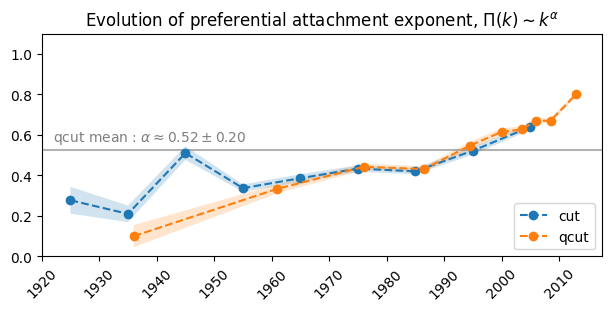

In [24]:
fig, ax = plt.subplots(figsize=(6, 3), constrained_layout=True)

mid_years = fitcoefs['year_bin'].bin.map(lambda x: (x.left + x.right)/2)
qmid_years = fitcoefs['year_qbin'].bin.map(lambda x: (x.left + x.right)/2)

alpha_mean, alpha_std = fitcoefs['year_qbin'].alpha.mean(), fitcoefs['year_qbin'].alpha.std()
ax.axhline(alpha_mean, alpha=0.6, color='tab:gray')
ax.annotate(f'qcut mean : $\\alpha \\approx {alpha_mean:.2f} \pm {alpha_std:.2f}$',
	xy=(0.02, alpha_mean+0.02), va='bottom', xycoords=('axes fraction', 'data'), color='tab:gray')
ax.fill_between(mid_years, fitcoefs['year_bin'].ci_lower, fitcoefs['year_bin'].ci_upper, alpha=0.2)
ax.fill_between(qmid_years, fitcoefs['year_qbin'].ci_lower, fitcoefs['year_qbin'].ci_upper, alpha=0.2)
ax.plot(mid_years, fitcoefs['year_bin'].alpha, 'o--', label='cut')
ax.plot(qmid_years, fitcoefs['year_qbin'].alpha, 'o--', label='qcut')

ax.set_xticks([ int(x.left) for x in fitcoefs['year_bin'].bin ] + [ int(fitcoefs['year_bin'].bin.iloc[-1].right) ])
ax.set_xticklabels(ax.get_xticks(), rotation=45)
ax.legend(loc='lower right')

ax.set_ylim((0.0, 1.1))
ax.set_title('Evolution of preferential attachment exponent, $\\Pi(k) \\sim k^{\\alpha}$')
plt.show()

This also confirms actors do indeed grow faster as they enter later into the graph !

### Degree distribution in the B-A model

<img src="../assets/Screenshot from 2022-12-13 20-42-26.png">

In [32]:
def p_k_th(alpha: float, k_mean: float):
	def p_k(k: np.ndarray) -> np.ndarray:
		p = k**(-alpha) * np.exp(-2/(k_mean*(1-alpha)) * k**(1-alpha))
		p /= p.sum()
		return p
	return p_k

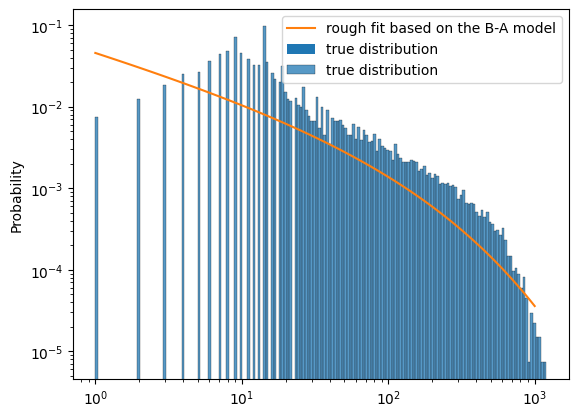

In [53]:
fig, ax = plt.subplots()

degrees_final = degrees[:, -1].copy()
degrees_final.sort()
sns.histplot(degrees_final, log_scale=(True, True), stat='probability', label='true distribution')

# year_to_idx = { year: i for i, year in enumerate(years) }
# k_means = [ np.nanmean(degrees[:, year_to_idx[int(qmid_year)]]) for qmid_year in qmid_years ]
k = np.logspace(0, 3, 100)
sns.lineplot(x=k, y=p_k_th(fitcoefs['year_qbin'].alpha.mean(), degrees_final.mean())(k),
	color='tab:orange', label='rough fit based on the B-A model')

# ax.set_xscale('log')
# ax.set_yscale('log')

ax.legend()
plt.show()

Problem : the cutoff is too sharp with our fits. it looks like the true alpha is smaller

Furthermore dead actors cannot stay in the graph, and thus "bias" the results to no attachment -> so in reality the alpha should be lower

### Growth of hubs

<img src="../assets/Screenshot from 2022-12-13 21-01-28.png">

In [55]:
kmax = np.nanmax(degrees, axis=0)

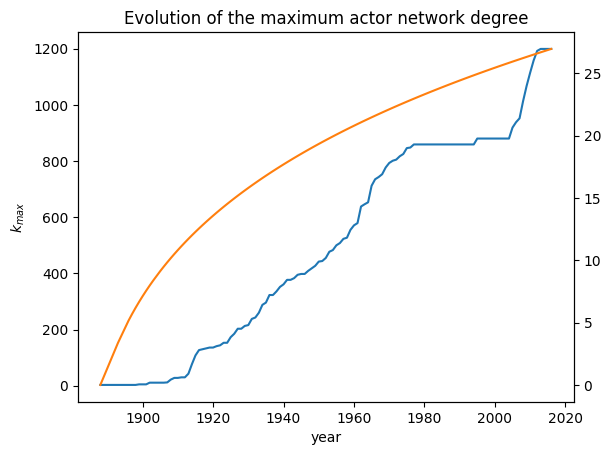

In [56]:
fig, ax = plt.subplots()
ax.plot(years, kmax)
ax.twinx().plot(years, np.log(years-years.min()+1)**(1/(1-0.52)), color='tab:orange')
ax.set_xlabel('year')
ax.set_ylabel('$k_{max}$')
ax.set_title('Evolution of the maximum actor network degree')
plt.show()

### Growth of components

In [67]:
if True:
	g = ig.Graph(directed=False)
	total_movies = 0
	components = []

	for year, df_edges_year in tqdm(df_edges.groupby('movie_release_year', sort=False)):
		current_actors = set([ v['name'] for v in g.vs ])
		actors_from_edges = set(df_edges_year.actor1_fbid.unique()) | set(df_edges_year.actor2_fbid.unique())
		new_actors = actors_from_edges - current_actors

		g.add_vertices(list(new_actors))
		g.add_edges(zip(df_edges_year.actor1_fbid, df_edges_year.actor2_fbid))

		total_movies += df_edges_year.movie_fbid.nunique()
		components.append((len(g.connected_components(mode='weak')), total_movies, year))

	df_components = pd.DataFrame(components, columns=['num_connected', 'num_movies', 'year'])

	if True:  # save to disk
		df_components.to_pickle('../data/generated/graph/network_growth/components.pkl')

else:
	df_components = pd.read_pickle('../data/generated/graph/network_growth/components.pkl')

100%|██████████| 122/122 [00:07<00:00, 16.77it/s]


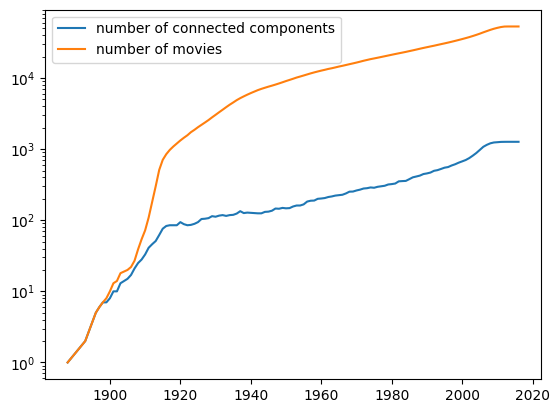

In [68]:
# at the start, every movie adds a new unique component, then the clusters start to appear !
fig, ax = plt.subplots()
ax.plot(df_components.year, df_components.num_connected, label='number of connected components')
ax.plot(df_components.year, df_components.num_movies, label='number of movies')
ax.set_yscale('log')
ax.legend()
plt.show()